# Домашнее задание
## Майнор НСТ
### Дедлайн 06.12.2024 12:00

### Загрузите работу в форму по ссылке закрепленной в конференции группы майнора

В данной работе вам предствоит классифицировать изображения цифр из датасета MNIST, который можно подгрузить из библиотеки torchvision

# Задание

1. Подгрузите набор данных MNIST, предобработайте (нормализуйте, при необходимости), создайте loader-ы для тестовых и тренировочных данных
1. Создайте нейронную сеть для классификации состоящуюю из (можете использовать контейнер Sequential, можете слоями как на семинаре):
+ Архитектура сверточной нейронной сети
- Данная архитектура должна состоять из convolution и pooling слоев и никаких более
+ Архитектура классификатор
- Данная архитектура должна состоять из линейных слоев (использование flatten как слоя тоже возможно, оценка за его использования снижена не будет)
2. В отедельной ячейки типа markdown по формуле, данной на семинаре, посчитайте выходную размерность карты признаков (желательно чтобы подсчет был оформлен в стиле LaTex, то есть красиво читаемые математические вычисления, а не 2*3/12 ** 3)
3. Напишите цикл обучения для вашей сети и выведите график обучения (функции потери от эпохи)
4. На тестовой выборке замерить метрику Accuracy и F1-score
5. Вывести 10 случайных тестовых примеров и над ними написать актуальную метку и метку предсказанную моделью.
6. Проведите исследования
+ необходимого количества эпох для обучения
+ поэксперементируйте с оптимизаторами (попробуйте SGD и Adam) (возможно поэксперементируйте с learning rate)
+ поэксперементируйте с сверточной архитектурой (добавьте или убавьте слои, измените размер ядра)
+ поэксперементируйте с размером батчей
7. Напишите вывод из своего исследования на основе пункта 6 и опишите какая модель показала себя наилучшим образом и какие наилучшие параметры.
8. Градация оценки зависит от выполнения всех пунктов выше корректно и метрики точности:
+ Accuracy < 0.6 - максимум 5 балов
+ Accuracy < 0.7 - максимум 6 балов
+ Accuracy < 0.8 - максимум 7 балов
+ Accuracy > 0.82 - 8 балов и выше

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
import torchvision.transforms as transforms

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.1MB/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.35MB/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 11.8MB/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.19MB/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [ ]:
print(train_dataset, test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset MNIST
    Number of datapoints: 10000
    Root location: ../../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


In [ ]:
print(train_loader, test_loader)

<torch.utils.data.dataloader.DataLoader object at 0x7dbff35b5090> <torch.utils.data.dataloader.DataLoader object at 0x7dbff35b6740>


In [ ]:
class NN(nn.Module):  # создаем модель, на которой будем экспериментировать
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # всего 3 линейных слоя (почему 3 напишу в конце тетрадки :) )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Подсчет размерностей:
- на вход нам подается черно-белая (1 канал) картинка цифры размером 28*28; на выходе получаем 6 фильтром размером 5x5
output = 28 - 5/1 + 1 = **24**  (на выходе получили 6x24x24)
- MaxPool2d(2, 2) -> уменьшает размер вдвое -> 16x12x12
- на выход 16 фильтров размеров 5x5
output = 12 - 5 / 1 + 1 = **8** (на выход получили 16x8x8)
- MaxPool2d(2, 2) -> уменьшает размер вдвое -> 16x4x4
- преобразование в вектор размерности 256 (16x4x4)
- 1 линейный слой: вход - 256, вывод - 120
- 2 линейный слой: вход - 120, вывод - 84
- 3 линейный слой: вход - 84, вывод - 10
** 10 потому что это совпадает с количеством "классов" в нашем датасете (количеству цифр)




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # для быстроты делаю на видеокарте

In [ ]:
model = NN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # в качестве эксперимента сначала выполняю с оптимизатором Adam

In [ ]:
losses_1 = []  # список для хранения значений потери модели на каждой эпохе

In [ ]:
for epoch in range(num_epochs):
    model.train().to(device)
    loss_1epoch = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_1epoch += loss.item()


        if (i + 1) % 103 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

    average_loss = loss_1epoch / len(train_loader)
    losses_1.append(average_loss)


Epoch [1/5], Step [103/938], Loss: 0.6637
Epoch [1/5], Step [206/938], Loss: 0.2424
Epoch [1/5], Step [309/938], Loss: 0.1348
Epoch [1/5], Step [412/938], Loss: 0.1122
Epoch [1/5], Step [515/938], Loss: 0.1890
Epoch [1/5], Step [618/938], Loss: 0.0451
Epoch [1/5], Step [721/938], Loss: 0.0599
Epoch [1/5], Step [824/938], Loss: 0.0744
Epoch [1/5], Step [927/938], Loss: 0.2182
Epoch [2/5], Step [103/938], Loss: 0.1032
Epoch [2/5], Step [206/938], Loss: 0.1220
Epoch [2/5], Step [309/938], Loss: 0.0484
Epoch [2/5], Step [412/938], Loss: 0.0235
Epoch [2/5], Step [515/938], Loss: 0.0157
Epoch [2/5], Step [618/938], Loss: 0.0604
Epoch [2/5], Step [721/938], Loss: 0.0392
Epoch [2/5], Step [824/938], Loss: 0.1242
Epoch [2/5], Step [927/938], Loss: 0.0420
Epoch [3/5], Step [103/938], Loss: 0.0102
Epoch [3/5], Step [206/938], Loss: 0.1054
Epoch [3/5], Step [309/938], Loss: 0.0153
Epoch [3/5], Step [412/938], Loss: 0.1305
Epoch [3/5], Step [515/938], Loss: 0.1580
Epoch [3/5], Step [618/938], Loss:

In [ ]:
print(losses_1)

[0.31413419625120187, 0.0881017721282926, 0.06098347281089434, 0.04925178444590857, 0.0406051009336411]


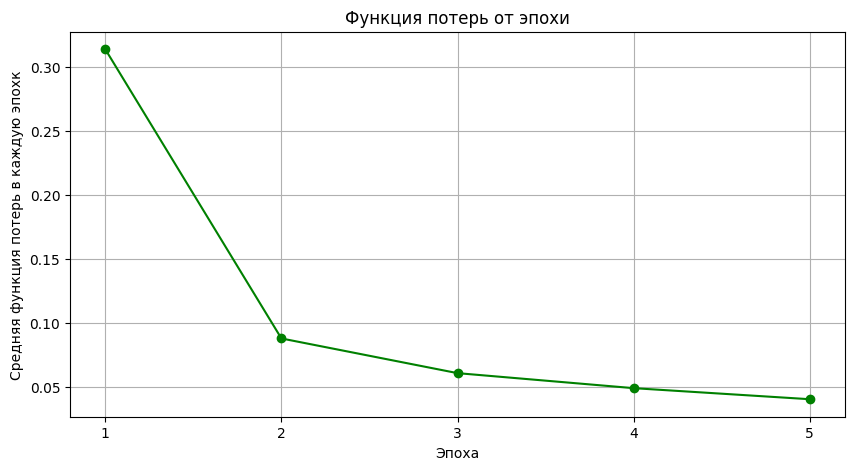

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), losses_1, marker='o', linestyle='-', color='g')
plt.title('Функция потерь от эпохи')
plt.xlabel('Эпоха')
plt.ylabel('Средняя функция потерь в каждую эпохк')
plt.xticks(range(1, 6))  # Устанавливаем метки по оси X для каждой эпохи
plt.grid()
plt.show()

In [ ]:
true_labels = []   # список для изначальных меток, которые были в датасете
preds = []  # cписок для предсказанныхт меток
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        preds.extend(predicted.cpu().numpy())


all_labels = np.array(true_labels)
all_preds = np.array(preds)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')


accuracy_percentage = accuracy * 100
f1_percentage = f1 * 100

print(f'Accuracy: {accuracy_percentage:.2f}')
print(f'F1 Score: {f1_percentage:.2f}')

Accuracy: 98.53
F1 Score: 98.53


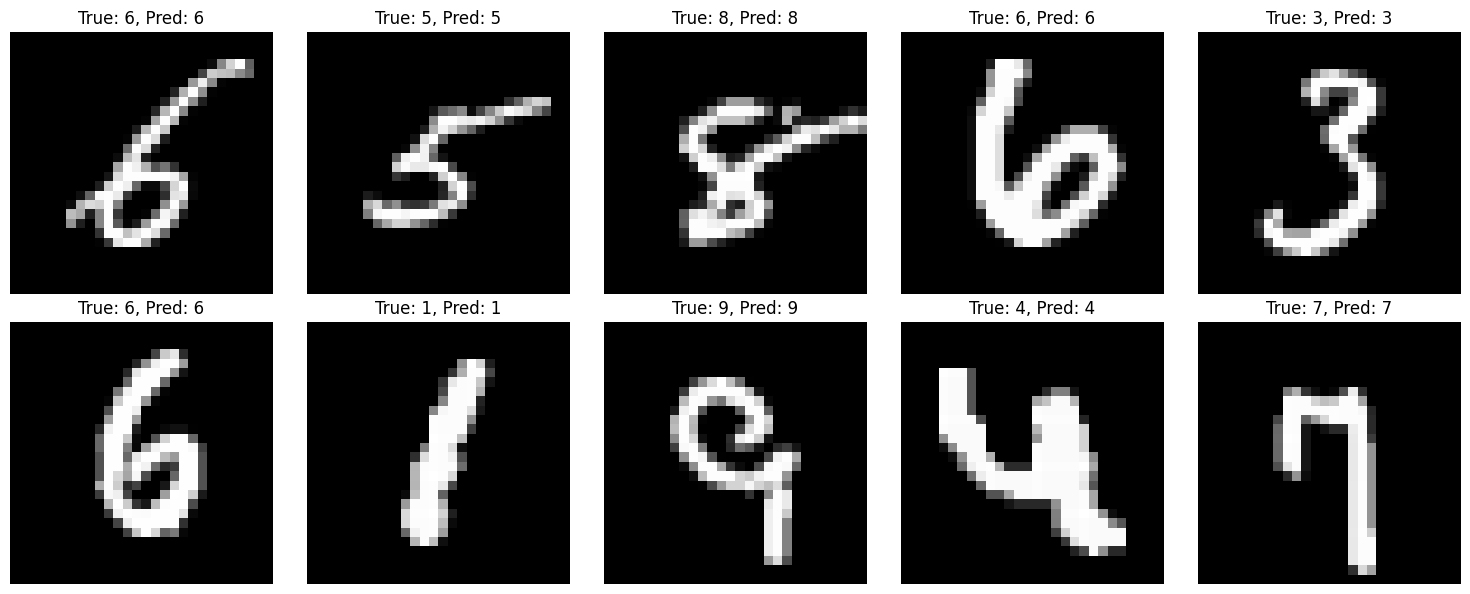

In [ ]:
# так как получились хорошие цифры с таким оптимизатором выведем 10 рандомных картинок
import random

num_examples = 10
random_indices = random.sample(range(len(test_dataset)), num_examples)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]
    image_tensor = image.unsqueeze(0).to(device)
    output = model(image_tensor)
    _, predicted_label = torch.max(output.data, 1)

    plt.subplot(2, num_examples // 2, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'True: {label}, Pred: {predicted_label.item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
learning_rate2 = 0.05
losses_2 = []

In [ ]:
# теперь проделываем все те же шаги, что и до этого, но уже с другим оптимизатором
model2 = NN().to(device)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate2)
criterion2 = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model2.train()
    loss_2epoch = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        loss = criterion2(outputs, labels)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        loss_2epoch += loss.item()

        if (i + 1) % 103 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

    average_loss2 = loss_2epoch / len(train_loader)
    losses_2.append(average_loss2)

Epoch [1/5], Step [103/938], Loss: 2.3050
Epoch [1/5], Step [206/938], Loss: 2.2036
Epoch [1/5], Step [309/938], Loss: 0.8059
Epoch [1/5], Step [412/938], Loss: 0.5037
Epoch [1/5], Step [515/938], Loss: 0.1623
Epoch [1/5], Step [618/938], Loss: 0.1683
Epoch [1/5], Step [721/938], Loss: 0.3092
Epoch [1/5], Step [824/938], Loss: 0.1864
Epoch [1/5], Step [927/938], Loss: 0.1643
Epoch [2/5], Step [103/938], Loss: 0.1524
Epoch [2/5], Step [206/938], Loss: 0.0517
Epoch [2/5], Step [309/938], Loss: 0.0531
Epoch [2/5], Step [412/938], Loss: 0.1384
Epoch [2/5], Step [515/938], Loss: 0.0260
Epoch [2/5], Step [618/938], Loss: 0.0940
Epoch [2/5], Step [721/938], Loss: 0.1388
Epoch [2/5], Step [824/938], Loss: 0.1962
Epoch [2/5], Step [927/938], Loss: 0.1048
Epoch [3/5], Step [103/938], Loss: 0.0396
Epoch [3/5], Step [206/938], Loss: 0.0581
Epoch [3/5], Step [309/938], Loss: 0.0525
Epoch [3/5], Step [412/938], Loss: 0.0884
Epoch [3/5], Step [515/938], Loss: 0.0223
Epoch [3/5], Step [618/938], Loss:

In [ ]:
print(losses_2)

[0.8510306592522336, 0.11715652162620206, 0.08172454291394651, 0.06295775694038862, 0.052375380179908344]


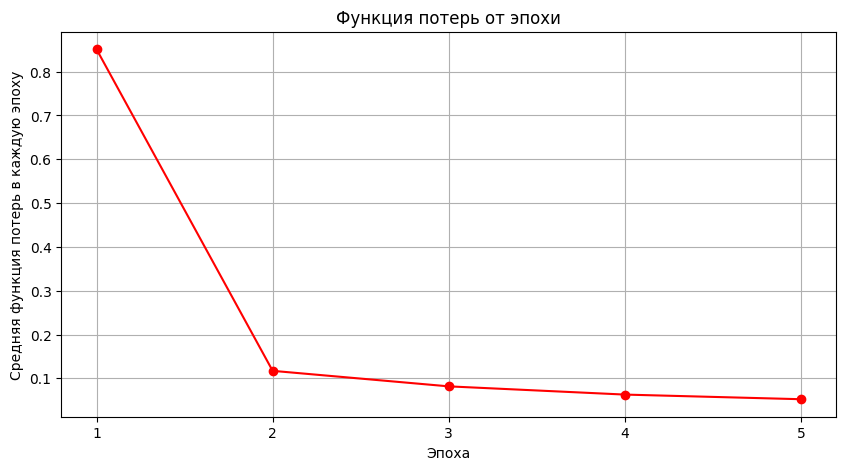

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), losses_2, marker='o', linestyle='-', color='r')
plt.title('Функция потерь от эпохи')
plt.xlabel('Эпоха')
plt.ylabel('Средняя функция потерь в каждую эпоху')
plt.xticks(range(1, 6))
plt.grid()
plt.show()

In [ ]:
true_labels2 = []
preds2 = []
model2.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels2.extend(labels.cpu().numpy())
        preds2.extend(predicted.cpu().numpy())


all_labels2 = np.array(true_labels2)
all_preds2 = np.array(preds2)

In [ ]:
accuracy2 = accuracy_score(all_labels2, all_preds2)
f1_2 = f1_score(all_labels2, all_preds2, average='weighted')


accuracy_percentage2 = accuracy2 * 100
f1_percentage2 = f1_2 * 100


print(f'Accuracy: {accuracy_percentage2:.2f}%')
print(f'F1 Score: {f1_percentage2:.2f}%')


Accuracy: 98.28%
F1 Score: 98.28%


Результаты эксперимента:
- Количество линейных слоев:
* изначально, в структуре моей модели было 2 линейных слоя, но при такой структуре accuracy не поднималось выше 70%, поэтому я сделала 3 линейных слоя, с которыми всё хорошо работает, поэтому я больше не экспериментировала с этими параметрами
- с размером батча я не экспериментировала
- количество эпох - 5:
* при меньшем (=2) количестве эпох значения accuracy было низким
* при количестве эпох = 10 сильно результаты не менялись, а обучение проходило дольше, поэтому было оставлено количество эпох = 5 (*при построении графиков уже было использовано количество эпох=5)
- learning rate:
* на основании эксперимента для оптимизатора adam нужно взять меньший learning rate = 0,001
* на основании эксперимента для оптимизатора sgd нужно взять больший learning rate = 0,05
- оптимизаторы:
* при разном learning rate получилось получить очень близкие результаты по метрикам accuracy и F1 score
* оптимизатор adam cправился с задачей немного лучше